<a href="https://colab.research.google.com/github/patelmahir649/Fashion-MNIST-Interpretability/blob/main/Interpretability_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **This notebook is an example for your intro interpretability projects for the coming weekend. I will create a basic CNN model for image classification on the Fashion-MNIST dataset, train it, and then use a couple interpretability functions to assess its performance. At the end of this tutorial, you can choose 1-2 interesting interpretability methods and test your own model!** bold text

In [ ]:
!pip install captum

import captum
import captum.attr as attr
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00


Specify a folder that you would like to store the training data in as "path"

In [ ]:
path = "/Users/ajfor/Documents"
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])
training_data = torchvision.datasets.MNIST(
    root= path,
    train=True,
    download=True,
    transform= image_transform
)

testing_data = torchvision.datasets.MNIST(
    root= path,
    train=False,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
)

train_dl = DataLoader(training_data, batch_size=64, shuffle=True)
test_dl = DataLoader(testing_data, batch_size=1024, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]


Extracting /Users/ajfor/Documents/MNIST/raw/train-images-idx3-ubyte.gz to /Users/ajfor/Documents/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 670kB/s]


Extracting /Users/ajfor/Documents/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/ajfor/Documents/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.86MB/s]


Extracting /Users/ajfor/Documents/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/ajfor/Documents/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.49MB/s]

Extracting /Users/ajfor/Documents/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/ajfor/Documents/MNIST/raw



Model is a simple CNN architecture.

In [ ]:
class image_classifier(nn.Module):
    def __init__(self):
        super(image_classifier, self).__init__()
        self.convBlock = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels = 16, kernel_size=5, stride = 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride = 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.convBlock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride = 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.convBlock(x)
        x = self.convBlock2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = image_classifier().to("cpu")

Training loop

In [ ]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
pbar_epoch = tqdm(range(num_epochs))
for epoch in range(num_epochs):
    total_train = 0
    correct_train = 0
    pbar_batch = tqdm(range(len(train_dl)))
    for batch, (images, labels) in enumerate(train_dl):
        images = images.to("cpu")
        labels = labels.to("cpu")
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_train += labels.size(0)
        _, predicted = torch.max(output.data, 1)
        correct_train += (predicted == labels).sum().item()
        pbar_batch.set_description(f"Batch {batch+1}/{len(train_dl)}")
        pbar_batch.update(1)
    pbar_batch.close()

    train_accuracy = 100 * correct_train / total_train
    print(f"Train Accuracy: {train_accuracy}% \n")
    pbar_epoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
    pbar_epoch.update(1)
pbar_epoch.close()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Train Accuracy: 85.33833333333334% 



  0%|          | 0/938 [00:00<?, ?it/s]

Train Accuracy: 93.19% 



  0%|          | 0/938 [00:00<?, ?it/s]

Train Accuracy: 93.82333333333334% 



  0%|          | 0/938 [00:00<?, ?it/s]

Train Accuracy: 94.35% 



  0%|          | 0/938 [00:00<?, ?it/s]

Train Accuracy: 94.815% 



Model Eval

In [ ]:
model.eval()
total = 0
correct = 0
pbar = tqdm(range(len(test_dl)))
for batch, (images, labels) in enumerate(test_dl):
    images = images.to("cpu")
    labels = labels.to("cpu")
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    pbar.set_description(f"Batch {batch+1}/{len(test_dl)}")
    pbar.update(1)

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")
pbar.close()

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 94.44%


Interpretability

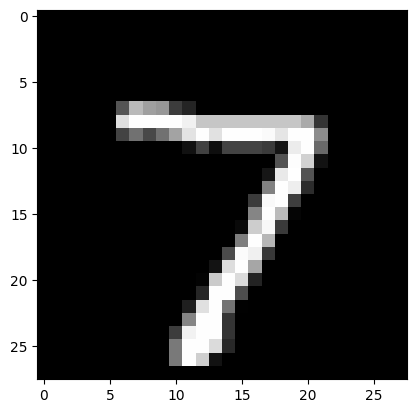

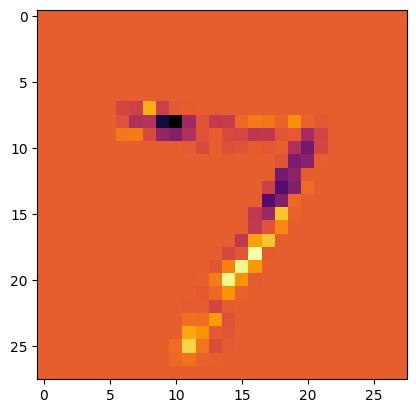

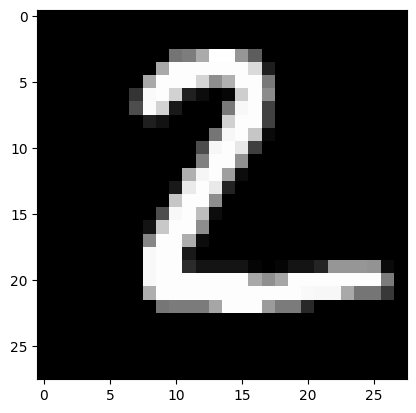

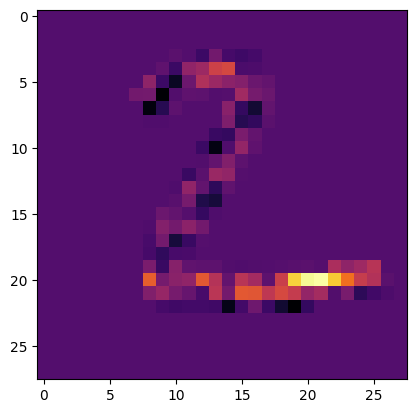

In [ ]:
ig = attr.IntegratedGradients(model)
_, label = testing_data[0]
test_sample = testing_data[0][0].unsqueeze(0).to("cpu")
test_sample2 = testing_data[1][0].unsqueeze(0).to("cpu")
plt.imshow(test_sample.squeeze().cpu().detach().numpy(), cmap='gray')
plt.show()
test_sample.requires_grad_()
attributions_ig = ig.attribute(test_sample, target=9)
plt.imshow(attributions_ig.squeeze().cpu().detach().numpy(), cmap='inferno')
plt.show()
plt.imshow(test_sample2.squeeze().cpu().detach().numpy(), cmap='gray')
plt.show()
attributions_ig2 = ig.attribute(test_sample2, target=testing_data[1][1])
plt.imshow(attributions_ig2.squeeze().cpu().detach().numpy(), cmap='inferno')
plt.show()



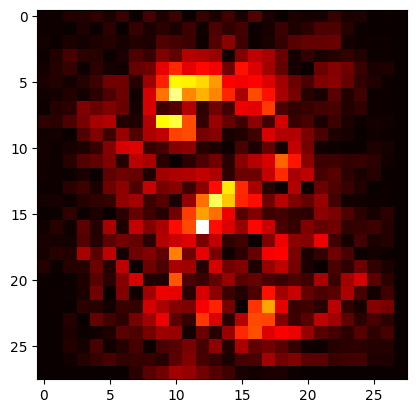

In [ ]:
from captum.attr import Saliency

# Initialize Saliency object
saliency = Saliency(model)

# Set the model to evaluation mode
model.eval()

# Compute saliency map for the first test sample
test_sample.requires_grad_()  # Ensure gradients can be computed
saliency_map = saliency.attribute(test_sample, target=label)  # Use the actual label

# Plot the saliency map
plt.imshow(saliency_map.squeeze().cpu().detach().numpy(), cmap='hot')
plt.show()


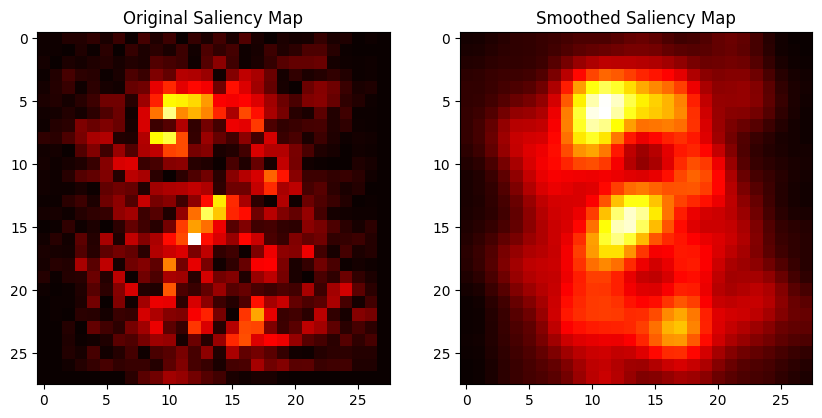

In [ ]:
import torch
from captum.attr import Saliency
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Initialize Saliency object
saliency = Saliency(model)

# Enable gradients for the input
test_sample.requires_grad_()

# Compute the saliency map for the sample with respect to the actual label
saliency_map = saliency.attribute(test_sample, target=label)

# Apply Gaussian smoothing to the saliency map
gaussian_smoothing = T.GaussianBlur(kernel_size=(5, 5), sigma=(1.5, 1.5))
smoothed_saliency_map = gaussian_smoothing(saliency_map)

# Plot original and smoothed saliency maps side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(saliency_map.squeeze().cpu().detach().numpy(), cmap='hot')
ax[0].set_title("Original Saliency Map")
ax[1].imshow(smoothed_saliency_map.squeeze().cpu().detach().numpy(), cmap='hot')
ax[1].set_title("Smoothed Saliency Map")
plt.show()

Patch at (0, 0) has a drop in confidence of 0.0000
Patch at (0, 7) has a drop in confidence of 0.0000
Patch at (0, 14) has a drop in confidence of 0.0000
Patch at (0, 21) has a drop in confidence of 0.0000
Patch at (7, 0) has a drop in confidence of 0.0000
Patch at (7, 7) has a drop in confidence of -0.0003
Patch at (7, 14) has a drop in confidence of 0.0001
Patch at (7, 21) has a drop in confidence of -0.0000
Patch at (14, 0) has a drop in confidence of 0.0000
Patch at (14, 7) has a drop in confidence of 0.0000
Patch at (14, 14) has a drop in confidence of 0.0000
Patch at (14, 21) has a drop in confidence of 0.0000
Patch at (21, 0) has a drop in confidence of 0.0000
Patch at (21, 7) has a drop in confidence of 0.0000
Patch at (21, 14) has a drop in confidence of -0.0000
Patch at (21, 21) has a drop in confidence of 0.0000


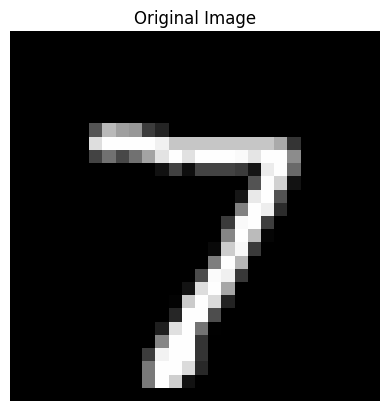

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def permute_image_patches(image, model, target_label, patch_size=(7, 7)):
    """
    Permute patches of an image and evaluate the impact on the model's prediction.

    Args:
        image: The input image tensor of shape (1, 1, 28, 28).
        model: The trained model.
        target_label: The label for which the prediction impact is evaluated.
        patch_size: The size of the patches to permute.

    Returns:
        List of tuples with coordinates of the patches and the drop in confidence.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Original prediction
    with torch.no_grad():
        original_output = model(image)
        original_pred = original_output.argmax(1).item()
        baseline_confidence = original_output[0, target_label].item()

    height, width = image.shape[2:4]
    perm_importances = []

    # Loop through the image in patches
    for i in range(0, height, patch_size[0]):
        for j in range(0, width, patch_size[1]):
            # Clone the original image
            permuted_image = image.clone()

            # Get the patch
            patch = permuted_image[:, :, i:i + patch_size[0], j:j + patch_size[1]]

            # Permute the pixel values of the patch
            flat_patch = patch.reshape(-1)  # Use reshape instead of view
            np.random.shuffle(flat_patch.numpy())  # Shuffle the pixel values

            # Reshape back to patch size
            permuted_patch = flat_patch.reshape(1, 1, patch_size[0], patch_size[1])  # Correctly reshape back

            # Place the permuted patch back in the image
            permuted_image[:, :, i:i + patch_size[0], j:j + patch_size[1]] = permuted_patch

            # Evaluate the model with the permuted image
            with torch.no_grad():
                permuted_output = model(permuted_image)
                permuted_confidence = permuted_output[0, target_label].item()

            # Calculate drop in confidence
            drop_in_confidence = baseline_confidence - permuted_confidence
            perm_importances.append(((i, j), drop_in_confidence))

    return perm_importances

# Ensure the model is defined and on the correct device
model = image_classifier().to("cpu")  # Adjust device as necessary

# Testing the feature permutation on a test sample
test_image, target_label = testing_data[0]
test_image = test_image.unsqueeze(0).to("cpu")  # Add batch dimension and move to device

# Apply feature permutation
importance_scores = permute_image_patches(test_image, model, target_label)

# Display the results
for (i, j), drop in importance_scores:
    print(f"Patch at ({i}, {j}) has a drop in confidence of {drop:.4f}")

# Optional: Visualize the original image
plt.imshow(test_image.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

